## Mel Spectrogram 2D CNN Demo

Problem: simplified version of [Kaggle's Freesound General-Purpose Audio Tagging Challenge](https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data#Freesound-General-Purpose-Audio-Tagging-Challenge), restricted to only two classes, "Laughter" and "Meow". The data consists of labeled "Laughter"/"Meow" .wav files sampled at 44.1 kHz. 

In [1]:
!pip install azure-storage==0.32.0

In [2]:
import numpy as np
import os
from azure.storage.blob import BlockBlobService, ContainerPermissions

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request as urllib2
import soundfile as sf
import io
from datetime import datetime,timedelta
from urllib.request import urlopen

%matplotlib inline
matplotlib.style.use('ggplot')

### 1) Get the data and restrict to "Laughter" and "Meow" classes

In [3]:
# connect to blob storage where data is stored
blob_account_name = "kagglemfccdata" 
blob_account_key = "lDTHYaywy8Zy+UFgdAAC+vNJ5PEt65Pj1gnT62Mek6B7KGXNnEzA/tZzsmhgelqHYXcUVuz13ALsmqjXhzv8RA=="       
blob_service = BlockBlobService(account_name=blob_account_name,
             account_key=blob_account_key)
sasurl = blob_service.generate_container_shared_access_signature("data",ContainerPermissions.READ,datetime.utcnow() + timedelta(hours=3))

In [4]:
# read in train and test data
train = pd.read_csv("train.csv")
test = pd.read_csv("test_post_competition.csv")

In [5]:
# restrict to only laughter and meowing classes for now
train = train[train["label"].isin(['Laughter', 'Meow'])]
train.index = np.arange(0,len(train))
test = test[test["label"].isin(['Laughter', 'Meow'])]
test.index = np.arange(0,len(test))

In [6]:
train.drop(["manually_verified"], axis=1, inplace=True)
test.drop(["usage", "freesound_id", "license"], axis=1, inplace=True)

In [7]:
labels = list(train.label.unique())
label_idx = {label: i for i, label in enumerate(labels)}
train["label_idx"] = train.label.apply(lambda x: label_idx[x])
test["label_idx"] = test.label.apply(lambda x: label_idx[x])

In [8]:
train.head()

,fname,label,label_idx
0,0097160c.wav,Laughter,0
1,00ad7068.wav,Laughter,0
2,00c934d7.wav,Laughter,0
3,024a193f.wav,Laughter,0
4,027cd3fd.wav,Meow,1


In [9]:
test.head()

,fname,label,label_idx
0,0586f0e0.wav,Meow,1
1,07c95625.wav,Meow,1
2,0a23fde2.wav,Meow,1
3,0c91a6b2.wav,Meow,1
4,17cb084e.wav,Laughter,0


In [10]:
n_classes = len(train.label.unique())
print("Number of training examples =", train.shape[0], "  Number of testing examples =", test.shape[0], "  Number of classes =", len(train.label.unique()))

Number of training examples = 455   Number of testing examples = 67   Number of classes = 2


In [11]:
print('Minimum train samples per category = ', min(train.label.value_counts()))
print('Maximum train samples per category = ', max(train.label.value_counts()))
print()
print('Minimum test samples per category = ', min(test.label.value_counts()))
print('Maximum test samples per category = ', max(test.label.value_counts()))

Minimum train samples per category =  155
Maximum train samples per category =  300

Minimum test samples per category =  29
Maximum test samples per category =  38


### 2) Featurization using Mel frequency spectrograms

In [12]:
!pip install librosa

In [13]:
import librosa
import librosa.display

In [14]:
!pip install tensorflow
!pip install keras

In [15]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras import optimizers, initializers

Using TensorFlow backend.


In [16]:
def prepare_data(df):
    sample_rate = 44100
    input_length = 2 * sample_rate # 88200, sample 2 seconds of audio
    num_mels = 40 # generate 40 mel bands
    X = np.empty(shape=(df.shape[0],num_mels,173,1))
    for i, row in df.iterrows():
        fname = row['fname']
        print(fname)
        
        blob_service = BlockBlobService(account_name=blob_account_name,
             account_key=blob_account_key)

        # URL to access the blob
        completeurl = "https://" + blob_account_name + ".blob.core.windows.net/" + mycontainer + "/" + fname  + '?' + sasurl  
        blob_res = urlopen(completeurl)
        blob_data = blob_res.read()
        data, rate = sf.read(io.BytesIO(blob_data))  
        
        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
            
        S = librosa.feature.melspectrogram(y=data, sr = rate, n_mels=num_mels)  
        log_S = librosa.core.power_to_db(S,ref=np.max)
        
        log_S = np.expand_dims(log_S,axis=-1)
        X[i,] = log_S

    return X

In [17]:
np.random.seed(1)
mycontainer = "data/audio_train"  
train_data = train
X_train = prepare_data(train_data)

0097160c.wav
00ad7068.wav
00c934d7.wav
024a193f.wav
027cd3fd.wav
03b4aca1.wav
041396a9.wav
0447d04d.wav
0632d921.wav
06712325.wav
0733ce78.wav
098c2232.wav
09986ba4.wav
0a32271b.wav
0b914d51.wav
0ba8bcc2.wav
0bd9f47b.wav
0c0f796c.wav
0ca8b59b.wav
0cbfebc7.wav
0cdfa126.wav
0dc26ae9.wav
0ec012fc.wav
0f274e7a.wav
0f6e2a63.wav
0f7f0d86.wav
11e63946.wav
1238c3a4.wav
13903b82.wav
14577fc0.wav
14ef39a2.wav
1516d630.wav
16caff03.wav
16d51b04.wav
170946f3.wav
174baf55.wav
1760ba6f.wav
188cfb1b.wav
18950b86.wav
196c8a34.wav
19fc7498.wav
1a707aaf.wav
1ae93472.wav
1b246359.wav
1cccb873.wav
1dc3679a.wav
1f83b349.wav
1fac40bb.wav
2072ebd5.wav
20c9fd28.wav
21e48c3b.wav
22e83dcb.wav
234a0656.wav
2372eeb4.wav
23b8788a.wav
2405de39.wav
2499fad5.wav
2539611b.wav
25a8c380.wav
25c99ad7.wav
27a962c5.wav
2a1540b1.wav
2ad59d34.wav
2ae34e2b.wav
2b6f431f.wav
2c1af1c2.wav
2e150054.wav
2e1973a4.wav
2e2fa0bf.wav
2e35864b.wav
2f06441d.wav
30619f79.wav
30819e5e.wav
32ce1b18.wav
335ef9e4.wav
33a40fbe.wav
3650faee.wav

In [18]:
np.random.seed(2)
mycontainer = "data/audio_test"  
test_data = test
X_test = prepare_data(test_data)

0586f0e0.wav
07c95625.wav
0a23fde2.wav
0c91a6b2.wav
17cb084e.wav
1a2f7f1a.wav
2442e7c6.wav
247a90a0.wav
2750c860.wav
288c4290.wav
2cb6b373.wav
30a320a3.wav
315e2cf1.wav
327bdcaa.wav
375d2777.wav
38ae005d.wav
39b23710.wav
41ee0c63.wav
4b036d3e.wav
4e2885b5.wav
4e395bf5.wav
54aa5112.wav
5b7ab76d.wav
63fd0268.wav
693994bb.wav
6a720a79.wav
763efe7a.wav
7a52fb48.wav
7c6c426f.wav
7e4fb0e6.wav
7eb3a36a.wav
803b5f25.wav
8123314e.wav
818be90b.wav
850e1d86.wav
8d55d1fa.wav
8f8b9651.wav
91553414.wav
98ec2bde.wav
9bb6e17e.wav
9d7e3931.wav
9d9dc988.wav
9f12eb4e.wav
a0c9407e.wav
a1c8ce98.wav
a2652019.wav
a37114c4.wav
ac755dd6.wav
ad142ed0.wav
b3b80eb6.wav
b8456dd4.wav
ba732e45.wav
bbe1a14c.wav
be92929b.wav
bf05bec8.wav
c74581f9.wav
ceef96eb.wav
d129bdd6.wav
d4363c06.wav
d4d395ee.wav
db8fb7dd.wav
e3f34b81.wav
e52a2307.wav
ee459aaf.wav
f1906c3d.wav
f52523f9.wav
ff96680f.wav


### 3) Train 2D CNN model using test set for validation using keras

CNN has the following layers:
- 2D convolution (16 nodes)
- Max pooling
- 2D convolution (16 nodes)
- Max pooling
- Flatten
- Dense (64 nodes)
- Dense (2 output nodes)

In [19]:
y_train = to_categorical(train['label_idx'], num_classes=n_classes)
y_test = to_categorical(test['label_idx'], num_classes=n_classes)

In [20]:
# create model
np.random.seed(1001)
initializers.RandomNormal(mean=0.0, stddev=0.1, seed=1)
model = Sequential()

# add model layers
model.add(Conv2D(16, kernel_size=(4,10), activation='tanh', input_shape=(40,173,1), padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, kernel_size=(4,10), activation='tanh', padding="same"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dense(n_classes, activation='softmax'))

# compile model using accuracy to measure model performance
opt = optimizers.Adam(0.0001) 
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

W0820 14:12:25.611278 14460 deprecation_wrapper.py:119] From C:\Users\brberton\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 14:12:25.636282 14460 deprecation_wrapper.py:119] From C:\Users\brberton\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 14:12:25.640279 14460 deprecation_wrapper.py:119] From C:\Users\brberton\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 14:12:25.659280 14460 deprecation_wrapper.py:119] From C:\Users\brberton\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please us

In [21]:
# train the model
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

W0820 14:12:25.819324 14460 deprecation.py:323] From C:\Users\brberton\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0820 14:12:25.872320 14460 deprecation_wrapper.py:119] From C:\Users\brberton\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 455 samples, validate on 67 samples
Epoch 1/20
455/455 [==============================] - 2s 5ms/step - loss: 0.7807 - acc: 0.5934 - val_loss: 0.9390 - val_acc: 0.5672
Epoch 2/20
455/455 [==============================] - 2s 4ms/step - loss: 0.5851 - acc: 0.7121 - val_loss: 0.6729 - val_acc: 0.5522
Epoch 3/20
455/455 [==============================] - 2s 4ms/step - loss: 0.5361 - acc: 0.7055 - val_loss: 0.5922 - val_acc: 0.7015
Epoch 4/20
455/455 [==============================] - 3s 6ms/step - loss: 0.4702 - acc: 0.7692 - val_loss: 0.5417 - val_acc: 0.7612
Epoch 5/20
455/455 [==============================] - 3s 6ms/step - loss: 0.4202 - acc: 0.8176 - val_loss: 0.4785 - val_acc: 0.8358
Epoch 6/20
455/455 [==============================] - 3s 6ms/step - loss: 0.3840 - acc: 0.8308 - val_loss: 0.5430 - val_acc: 0.7313
Epoch 7/20
455/455 [==============================] - 3s 6ms/step - loss: 0.3370 - acc: 0.8681 - val_loss: 0.4089 - val_acc: 0.8657
Epoch 8/20
455/455 [===========

### 4) Check model prediction for mystery File #3

Text(0.5, 1.0, 'File #3')

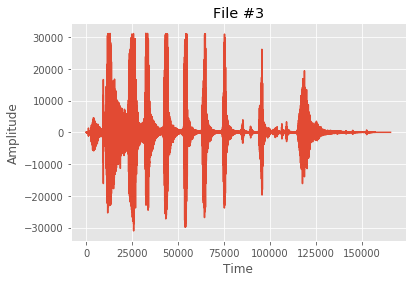

In [22]:
# display audio data
from scipy.io import wavfile
mydatafile = "188cfb1b.wav"  
mycontainer = "data/audio_train"
blob_service.get_blob_to_path(mycontainer, mydatafile, mydatafile)
rate, data = wavfile.read(mydatafile)
plt.plot(data, '-', )
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("File #3")

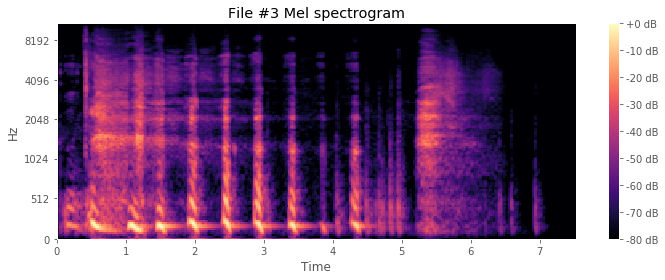

In [23]:
# Mel frequency spectrogram for File #3
sample_rate = 44100
data, rate = librosa.load(mydatafile, sr=sample_rate)
S = librosa.feature.melspectrogram(y=data, sr = rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.core.power_to_db(S,
                          ref=np.max),
                          y_axis='mel',
                          x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('File #3 Mel spectrogram')
plt.tight_layout()
plt.show()

In [24]:
# File #3

data_file3 = train[train["fname"].isin(['188cfb1b.wav'])]
data_file3.index = np.arange(0,len(data_file3))
mycontainer = "data/audio_train"  
X_file3 = prepare_data(data_file3)
y_file3 = to_categorical(data_file3['label_idx'], num_classes=n_classes)
y_file3_pred = model.predict(X_file3)
y_file3_pred 

188cfb1b.wav


array([[0.97114694, 0.02885301]], dtype=float32)

### Model predicts 97% chance that File #3 is laughter

In [25]:
import IPython.display as ipd  # module to play sound in notebook

blob_account_name = "kagglemfccdata" 
blob_account_key = "lDTHYaywy8Zy+UFgdAAC+vNJ5PEt65Pj1gnT62Mek6B7KGXNnEzA/tZzsmhgelqHYXcUVuz13ALsmqjXhzv8RA=="       
blob_service = BlockBlobService(account_name=blob_account_name,
             account_key=blob_account_key)
mycontainer = "data/audio_train"  
mydatafile = "188cfb1b.wav"    # file #3
blob_service.get_blob_to_path(mycontainer, mydatafile, mydatafile)

ipd.Audio(mydatafile)